In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ckdtree as kdtree 
import itertools
%matplotlib inline

In [2]:
#read in TGAS data for and matched sample for magnitudes 
tgas = fits.getdata("stacked_tgas.fits", 1)
tgasRave = fits.getdata('tgas-rave.fits', 1)
matchTgasApass = fits.getdata('tgas-matched-apass-dr9.fits')

In [25]:
print tgasRave.dtype.names
print tgas.dtype.names
print matchTgasApass.dtype.names

('hip', 'tycho2_id', 'solution_id', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'astrometric_relegation_factor', 'astrometric_weight_al', 'astrometric_weight_ac', 'astrometric_priors_used', 'matched_observations', 'duplicated_source', 'scan_direction_strength_k1', 'scan_direction_strength_k2', 'scan_direction_strength_k3', 'scan_direction_strength_k4', 'scan_direction_mean_k1', 'scan_direction_mean_k2', 'scan_direction_mean

In [4]:
raveInd = np.in1d(tgas['source_id'], tgasRave['source_id'])

In [5]:
#print np.array(tgas.dtype.names).T
#print np.array(tgasRave.dtype.names).T

In [6]:
#read in Adrian's distances from sampling the posterior 
ndist = 100
nfiles = 16
dist = None #np.zeros(len(tgasMatched), ndist)
for j in range(1,nfiles+1):
    with h5py.File("distance-samples-{:02d}.hdf5".format(j)) as f:
        if dist is None:
            dist = f['distance'][:,:ndist]
        else:
            dist = np.concatenate((dist, f['distance'][:,:ndist]))

In [7]:
#calculate the median distance from the posterior 
medianDist = np.median(dist, axis=1)

In [80]:
#various cuts to select sample 
proj = 'twins'
ndist = ndist
nNeighbors = 100
sigMax = 0.1
maxDist = 8000. #1000. #pc
fracErrorDistance = 1.

if proj ==  'twins':
    minDist = 0.0 #pc
    parallaxSN = 16.
    galacticLatMin = 30. #degrees
    galacticLatMax = None #degrees
if proj == 'dust':
    minDist = 250. #pc
    parallaxSN = 5.
    galacticLatMin = 0.  #degrees 
    galacticLatMax = 10. #degrees
    
mags = ['bmag', 'gmag', 'vmag', 'rmag', 'imag']
errors = ['e_bmag', 'e_gmag', 'e_vmag', 'e_rmag', 'e_imag']
wavelength = [420., 475., 520., 658., 806.]

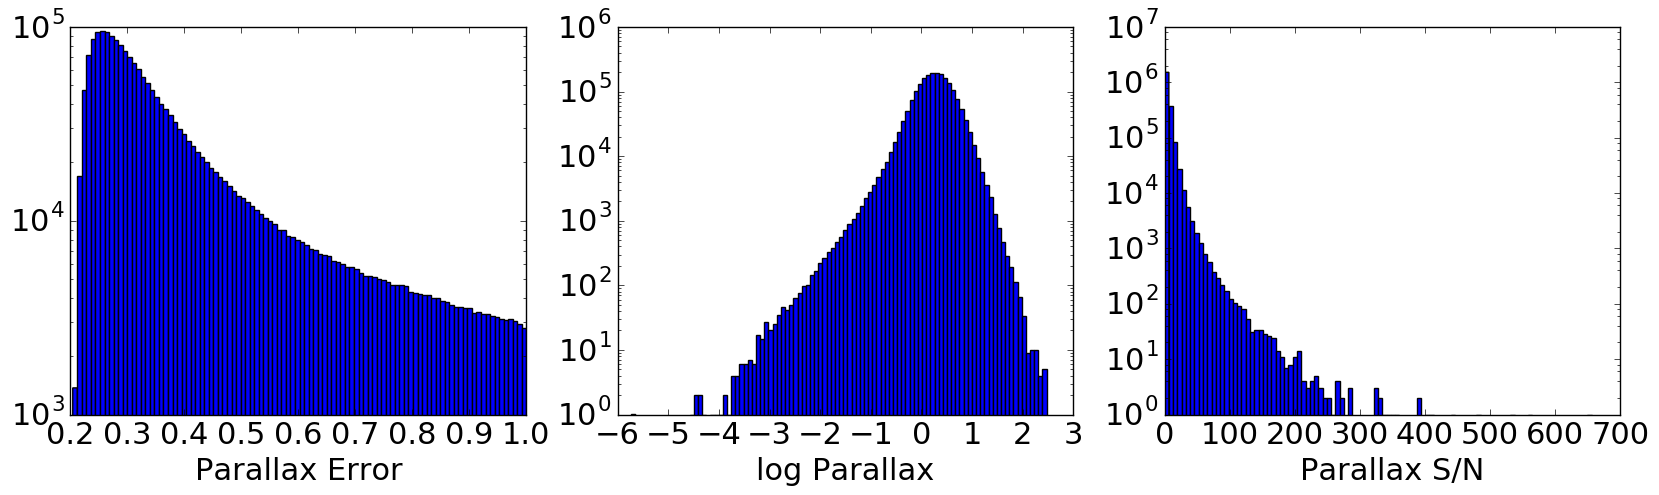

In [81]:
#visualize historgrams of parallax errors 
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1, 3, figsize=(20,5))
notNan = ~np.isnan(tgas['parallax']) & (tgas['parallax'] > 0.0)
nbins=100
err = np.sqrt(tgas['parallax_error']**2. + 0.3**2.)
out = axes[0].hist(tgas['parallax_error'][notNan], log=True, bins=nbins)
out = axes[1].hist(np.log10(tgas['parallax'][notNan]), log=True, bins=nbins)
out = axes[2].hist(tgas['parallax'][notNan]/err[notNan], log=True, bins=nbins)

axes[0].set_xlabel('Parallax Error')
axes[1].set_xlabel('log Parallax')
axes[2].set_xlabel('Parallax S/N')

In [82]:
#current cut: no magnitudes are NaNs, 0 < errors < sigMax, 
#print np.sum(tgas['parallax']/err > parallaxSN)

noNans = ~np.isnan(matchTgasApass['bmag']) & ~np.isnan(matchTgasApass['vmag']) & \
         ~np.isnan(matchTgasApass['gmag']) & ~np.isnan(matchTgasApass['rmag']) & \
         ~np.isnan(matchTgasApass['imag'])

posErrors = (matchTgasApass['e_bmag'] > 0) & (matchTgasApass['e_vmag'] > 0) & \
            (matchTgasApass['e_gmag'] > 0) & (matchTgasApass['e_rmag'] > 0) & \
            (matchTgasApass['e_imag'] > 0)

lowPhotError = (matchTgasApass['e_bmag'] < sigMax) & (matchTgasApass['e_vmag'] < sigMax) & \
               (matchTgasApass['e_gmag'] < sigMax) & (matchTgasApass['e_rmag'] < sigMax) & \
               (matchTgasApass['e_imag'] < sigMax)

noDust = (medianDist < maxDist) & (np.abs(tgas['b']) > galacticLatMin)

apassMatch = matchTgasApass['matched']

goodDistance = tgas['parallax']/err > parallaxSN

hasDust = medianDist >= minDist

raveInd = raveInd

if galacticLatMax: inDisk = np.abs(tgas['b'] <= galacticLatMax)

matched = goodDistance & noNans & posErrors & lowPhotError & noDust & apassMatch & raveInd

/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less


In [83]:
tgasMatched = tgas[matched]
magsMatched = matchTgasApass[matched]
errMatched = err[matched]

In [84]:
print 'Number of tgas stars: ', len(tgas)
print 'Number of matched stars: ', np.sum(matched)
print 'Percent matched = ', 100 - (len(tgas) - np.sum(matched))/np.float(len(tgas))*100., '%'
#print np.min(magsMatched['gmag']), np.max(magsMatched['gmag'])

Number of tgas stars:  2057050
Number of matched stars:  1621
Percent matched =  0.0788021681534 %


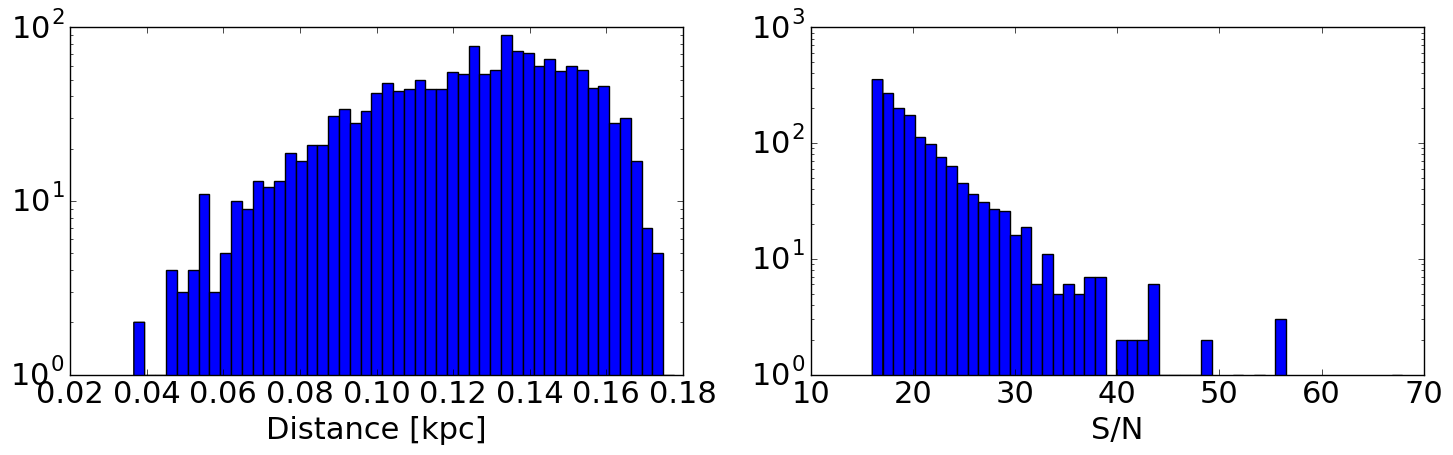

In [85]:
distMatched = dist[matched]
distUnmatched = dist[~matched]
medianDistMatched = np.median(distMatched, axis=1)
meanDistMatched = np.mean(distMatched, axis=1)
medianDistUnmatched = np.median(distUnmatched, axis=1)
fig, axes = plt.subplots(1,2, figsize=(15, 5))
out = axes[0].hist(medianDistMatched/1000., bins=50, log=True)
out = axes[1].hist(tgas['parallax'][matched]/err[matched], bins=50, log=True)
#out = axes[1].hist(np.log10(tgasMatched['parallax_error']))
#out = axes[1].hist(magsMatched['gmag'], bins=50, log=True)
axes[0].set_xlabel('Distance [kpc]')
axes[1].set_xlabel('S/N')
plt.tight_layout()
fig.savefig('distanceTgas.png')

In [86]:
def absMag(apparentMag, distance):
    return apparentMag - 5.*np.log10(distance/10.)

In [87]:
M_b = absMag(magsMatched['bmag'], medianDistMatched)
M_g = absMag(magsMatched['gmag'], medianDistMatched)
M_v = absMag(magsMatched['vmag'], medianDistMatched)
M_r = absMag(magsMatched['rmag'], medianDistMatched)
M_i = absMag(magsMatched['imag'], medianDistMatched)

In [88]:
B_V = magsMatched['bmag'] - magsMatched['vmag']
g_r = magsMatched['gmag'] - magsMatched['rmag']
r_i = magsMatched['rmag'] - magsMatched['imag']

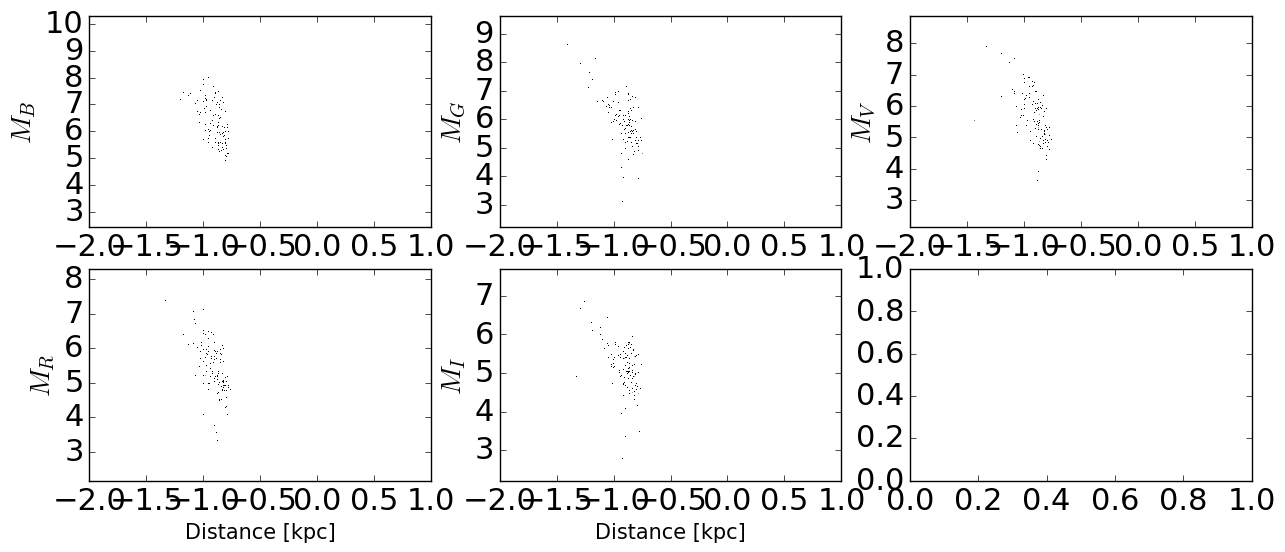

In [89]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.ravel()
ylabels = ['$M_B$', '$M_G$', '$M_V$', '$M_R$', '$M_I$']
bands = [M_b, M_g, M_v, M_r, M_i]
for ax, i in zip(axes, np.arange(len(bands))):
    out = ax.hist2d(np.log10(medianDistMatched/1000.), bands[i], bins=500, norm=LogNorm(), cmap=plt.get_cmap('gray'))
    if i in [3, 4]: ax.set_xlabel('Distance [kpc]', fontsize=15)
    ax.set_ylabel(ylabels[i], fontsize=20)
    ax.set_xlim(-2, 1)

In [90]:
tree = kdtree.cKDTree(data=zip(M_b, M_g, M_v, M_r, M_i))

In [91]:
treeColor = kdtree.cKDTree(data=zip(M_v, B_V, g_r, r_i))

In [92]:
def chisq(data, value, error):
    return np.sqrt(np.sum(((data - value)/error)**2.))/len(data)

In [93]:
import pdb
#some magsMatched[matchedInd, sourceInd] have 0.0 error :/

def distMetric(sourceInd, matchedInd, p=False):
    colorChiSq = 0.0
    colors = [B_V, g_r, r_i]
    color_errors = [['e_bmag', 'e_vmag'], ['e_gmag', 'e_rmag'], ['e_rmag', 'e_imag']]
    for color, error in zip(colors, color_errors):
        #print mag, error, sourceInd, matchedInd
        colorChiSq += (color[sourceInd] - color[matchedInd])**2./\
                      (magsMatched[error[0]][sourceInd]**2. + magsMatched[error[1]][sourceInd]**2. + \
                       magsMatched[error[0]][matchedInd]**2.+ magsMatched[error[1]][matchedInd]**2.)
        if p: print colorChiSq
    absMagChiSq = (M_v[sourceInd] - M_v[matchedInd])**2./\
                   (magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                  (errMatched[sourceInd]*1e-3 *5./np.log(10)*medianDistMatched[sourceInd])**2. +\
                  (errMatched[matchedInd]*1e-3*5./np.log(10)*medianDistMatched[matchedInd])**2.)
    totChiSq = np.sqrt(colorChiSq + absMagChiSq)
    if p:
        print 'the total chi2: ',totChiSq
        print 'the color chi2: ' ,colorChiSq
        print 'the absmag chi2:',absMagChiSq
    #if np.sum(np.isinf(totChiSq)): pdb.set_trace()
    return totChiSq

In [94]:
#check ChiSq are what you think they are, correct length, why inf?
sources = []
matches = []
nstars = np.sum(matched)
chisqThreshold = 2.
chisqApass = []
for star in np.arange(nstars): #np.arange(len(M_v)):
    pts = [M_v[star], B_V[star], g_r[star], r_i[star]]
    treeDistNum, treeIndNum = treeColor.query(pts, k=200) #nNeighbors)
    treeIndNum = treeIndNum[1:]
    chisq = distMetric(star, treeIndNum, p=False) 
    chisqApass.append(chisq[chisq < chisqThreshold])
    #print chisq
    treeIndNum = treeIndNum[chisq < chisqThreshold]
    sources.append(star)
    matches.append(treeIndNum)

In [95]:
def distRave(sourceInd, matchesInd):
    chisq = (tgasRave['TEFF'][sourceInd] - tgasRave['TEFF'][matchesInd])**2./(tgasRave['E_TEFF'][sourceInd]**2. + tgasRave['E_TEFF'][matchesInd]**2.) + \
            (tgasRave['LOGG'][sourceInd] - tgasRave['LOGG'][matchesInd])**2./(tgasRave['E_LOGG'][sourceInd]**2. + tgasRave['E_LOGG'][matchesInd]**2.) + \
            (tgasRave['FE_H'][sourceInd] - tgasRave['FE_H'][matchesInd])**2./(tgasRave['E_FE_H'][sourceInd]**2. + tgasRave['E_FE_H'][matchesInd]**2.)
    return chisq 
            

In [96]:
indices = []
raveSource = []
raveMatch = []
chisqRave = []
for s, m in zip(sources, matches):
    raveStarInd = np.where(np.in1d(tgasRave['source_id'], tgasMatched[s]['source_id']))[0]
    raveMatchInd = np.where(np.in1d(tgasRave['source_id'], tgasMatched[m]['source_id']))[0]
    
    raveSource.append(raveStarInd)
    raveMatch.append(raveMatchInd)
    indices.append(np.concatenate((raveStarInd, raveMatchInd)))

    chisq = distRave(raveStarInd, raveMatchInd)
    chisqRave.append(chisq)
#print indices

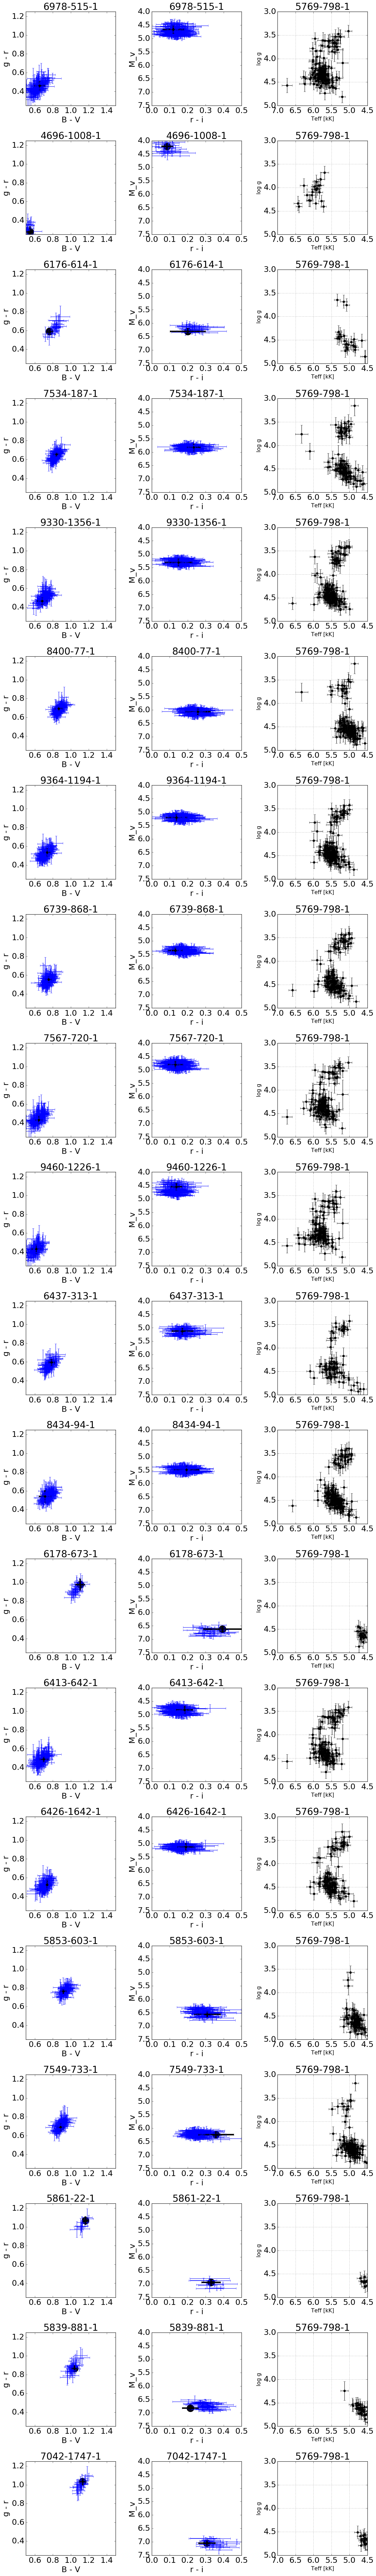

In [97]:
nplot = 20
fig, ax = plt.subplots(nplot, 3, figsize=(15, nplot*5))
axes = itertools.cycle(ax.ravel())

b_v_lim = [0.5, 1.5]
g_r_lim = [0.25, 1.25]

r_i_lim = [0, 0.5]
M_v_lim = [7.5, 4.0]

teff_lim = [7, 4.5] #kK
log_g_lim = [5, 3] 

for j in np.random.randint(0, high=len(indices), size=nplot):
    ax = axes.next()
    twins = matches[j]
    star = sources[j]
    raveTwins = indices[j]
    #plot B-V vs g-r for the source and twins 
    ax.set_title(tgasMatched['tycho2_id'][star])
    ax.errorbar(B_V[twins], g_r[twins], 
                xerr = np.sqrt(magsMatched['e_bmag'][twins]**2. + magsMatched['e_vmag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][twins]**2. + magsMatched['e_rmag'][twins]**2.), fmt="none", color='blue')
    #ax.scatter(B_V[treeIndNum], g_r[treeIndNum], c=colors, s=200)
    ax.errorbar(B_V[star], g_r[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][star]**2. + magsMatched['e_rmag'][star]**2.), fmt='o', color='black',lw=4)

    ax.scatter(B_V[star], g_r[star], s=400, c='black')
    ax.set_xlabel('B - V')
    ax.set_ylabel('g - r')
    ax.set_ylim(g_r_lim)
    ax.set_xlim(b_v_lim)

    #plot r-i and M_v for the source and twins
    ax = axes.next()
    ax.set_title(tgasMatched['tycho2_id'][star])
    ax.errorbar(r_i[twins], M_v[twins], 
                xerr = np.sqrt(magsMatched['e_rmag'][twins]**2. + magsMatched['e_imag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][twins]**2. + (errMatched[twins]*1e-3 *5./np.log(10)*medianDistMatched[twins])**2.),
                              fmt="none", color='blue')
    #ax.scatter(B_V[treeIndNum], M_v[treeIndNum], c=colors, s=100, lw=None)
    ax.errorbar(r_i[star], M_v[star], 
                xerr = np.sqrt(magsMatched['e_rmag'][star]**2. + magsMatched['e_imag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][star]**2. + \
                               (errMatched[star]*1e-3 *5./np.log(10)*medianDistMatched[star])**2.), fmt='o', color='black', lw=4)

    ax.scatter(r_i[star], M_v[star], s=400, c='black')
    ax.set_xlabel('r - i')
    ax.set_ylabel('M_v')
    ax.set_xlim(r_i_lim)
    ax.set_ylim(M_v_lim)
    
    #plot Teff vs log g for the source and twins 
    ax = axes.next()
    ax.set_title(tgasMatched['tycho2_id'][s])
    ax.errorbar(tgasRave['TEFF'][raveTwins]/1000., tgasRave['LOGG'][raveTwins], xerr=tgasRave['E_TEFF'][raveTwins]/1000., yerr=tgasRave['E_LOGG'][raveTwins],
               fmt='o', color='black')
    ax.set_ylabel('log g', fontsize=15)
    ax.set_xlabel('Teff [kK]', fontsize=15)
    ax.set_xlim(teff_lim)
    ax.set_ylim(log_g_lim)
    ax.grid()
plt.tight_layout()

123
123


/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


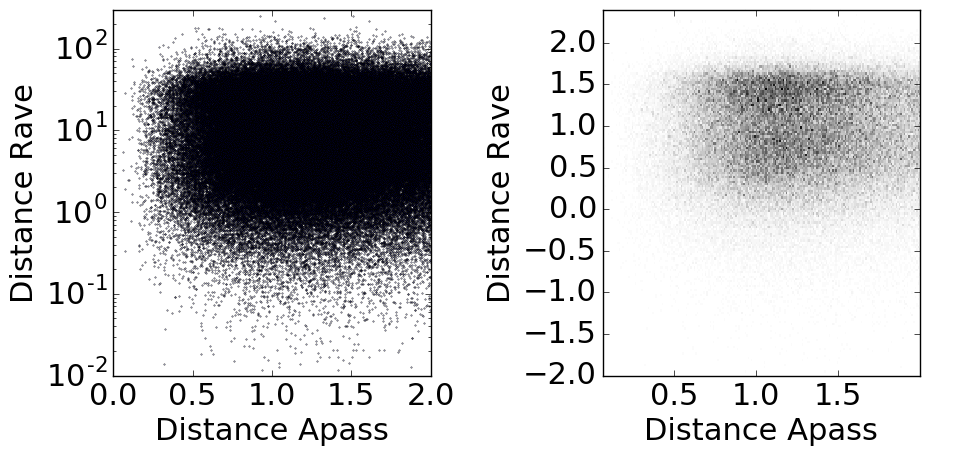

In [114]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
print len(chisqApass[0])
print len(chisqRave[0])
allChisqPhot = []
allChisqSpec = []

for chisqPhot, chisqSpec in zip(chisqApass, chisqRave):
    ax[0].scatter(chisqPhot, chisqSpec, s=0.1)
    allChisqPhot = np.concatenate((allChisqPhot, chisqPhot))
    allChisqSpec = np.concatenate((allChisqSpec, chisqSpec))
ax[0].set_xlim(0,chisqThreshold)
ax[0].set_ylim(1e-2,)
ax[0].set_yscale('log')
ax[0].set_xlabel('Distance Apass')
ax[0].set_ylabel('Distance Rave')

nonNan = ~np.isnan(allChisqPhot) & ~np.isnan(allChisqSpec) & (allChisqSpec > 0)
ax[1].hist2d(allChisqPhot[nonNan], np.log10(allChisqSpec[nonNan]), bins=200, cmap='Greys')
ax[1].set_ylim(-2,)
ax[1].set_xlabel('Distance Apass')
ax[1].set_ylabel('Distance Rave')
plt.tight_layout()

/mnt/xfs1/scda_software/pkg/devel/python/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


(-2, 2.4003899593971405)

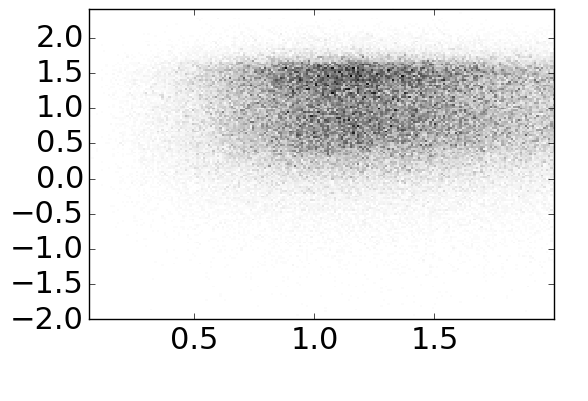

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 25}) 
for j, i in enumerate(indices):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.errorbar(tgasRave['TEFF'][i]/1000., tgasRave['LOGG'][i], xerr=tgasRave['E_TEFF'][i]/1000., yerr=tgasRave['E_LOGG'][i],
               fmt='o', color='black')
    ax.set_ylabel('log g')
    ax.set_xlabel('Teff [kK]')
    ax.set_xticks([5, 6, 7])
    ax.set_xlim(4.5, 7)
    ax.set_ylim(3, 5)
    ax.grid()
    plt.tight_layout()
    fig.savefig('stellarTwins.' + str(j) + '.png')

In [ ]:
for i in indices:
    for j in i:
        text = 'Tycho2 Id: ' + str(tgasRave[j]['tycho2_id']) + '\n' + \
       'pmra: ' + "{:.2f}".format(np.float(tgasRave[j]['pmra'])) + '\n' + \
       'pmdc: ' + "{:.2f}".format(np.float(tgasRave[j]['pmdec'])) + '\n' + \
       'vrad: ' + "{:.2f}".format(np.float(tgasRave[j]['HRV']))
        print text